# Imports

In [1]:
!pip install tensorflow==2.3
!pip install keras==2.2.4
!pip install tf-models-official==2.3.0 pydot graphviz

In [2]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)

from keras.utils import np_utils

#from keras import backend as K

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Using TensorFlow backend.


3 Physical GPUs, 3 Logical GPUs
Version:  2.3.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
#let's work with the non-toxic data first

In [9]:
df_test = pd.read_csv('GermEval_data/GermEval21_Toxic_TestData.csv', encoding= 'UTF-8')
df_test.rename(columns = {'c_text':'comment_text'}, inplace = True)
df_test

,comment_id,comment_text
0,3245,@USER Sie würden wahrscheinlich auch einen Kri...
1,3246,"@USER , ich glaube,Sie verkrnnen gründlich die..."
2,3247,@USER: Man kann natürlich immerzu dieselbe Sau...
3,3248,"Als jemand, der im real existierenden Sozialis..."
4,3249,Ihr größter Erfolg in ihrem Leben? KLASSENSPRE...
...,...,...
939,4184,@USER Da ist wie gegen Windmühlen kämpfen
940,4185,@USER Ihr Wort in Gottes Ohr.
941,4186,😂
942,4187,Mimimimi


Old code

In [10]:
df_train = pd.read_csv('data_fragments_base/dataset_with_synthetic.csv', encoding = 'UTF-8')
df_train

,Sub1_Toxic,Sub2_Engaging,Sub3_FactClaiming,comment_id,comment_text
0,0,0.0,0.0,1.0,Ziemlich traurig diese Kommentare zu lesen. Ih...
1,0,1.0,1.0,2.0,"Sag ich doch, wir befeuern den Klimawandel. Ra..."
2,1,0.0,0.0,3.0,"Schublade auf, Schublade zu. Zu mehr Denkleist..."
3,0,0.0,1.0,4.0,Dummerweise haben wir in der EU und in der USA...
4,0,0.0,0.0,5.0,"""So lange Gewinnmaximierung Vorrang hat, wird ..."
...,...,...,...,...,...
6239,1,NaN,NaN,NaN,@USER um nicht eine Deutschlanden sieht die Ki...
6240,1,NaN,NaN,NaN,Hollandt überwohnung hat heimlich gegen die si...
6241,1,NaN,NaN,NaN,Och mal nicht die kunst du mich auch der Reisc...
6242,1,NaN,NaN,NaN,"Ich sicke, mei ich schon auch mal dann leben z..."


We'll only work with Task 1 Labels here

In [11]:
df_train.Sub1_Toxic.unique()

array([0, 1])

In [12]:
df_train['Sub1_Toxic'] = df_train['Sub1_Toxic'].astype(int)

In [13]:
df_train['comment_text'] = df_train['comment_text'].astype(object)

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6244 entries, 0 to 6243
Data columns (total 5 columns):
Sub1_Toxic           6244 non-null int64
Sub2_Engaging        3244 non-null float64
Sub3_FactClaiming    3244 non-null float64
comment_id           3244 non-null float64
comment_text         6242 non-null object
dtypes: float64(3), int64(1), object(1)
memory usage: 244.0+ KB


//Old code

In [14]:
df_train = pd.read_csv('data_fragments_base/dataset_with_syntheticII.csv', encoding = 'UTF-8')
df_train
#del df['Unnamed: 5']
#del df['Unnamed: 8']
#df.head()

,Sub1_Toxic,comment_text
0,0,Ziemlich traurig diese Kommentare zu lesen. Ih...
1,0,"Sag ich doch, wir befeuern den Klimawandel. Ra..."
2,1,"Schublade auf, Schublade zu. Zu mehr Denkleist..."
3,0,Dummerweise haben wir in der EU und in der USA...
4,0,"""So lange Gewinnmaximierung Vorrang hat, wird ..."
...,...,...
6239,1,@USER um nicht eine Deutschlanden sieht die Ki...
6240,1,Hollandt überwohnung hat heimlich gegen die si...
6241,1,Och mal nicht die kunst du mich auch der Reisc...
6242,1,"Ich sicke, mei ich schon auch mal dann leben z..."


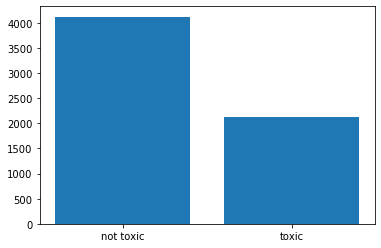

In [15]:
classes = df_train.Sub1_Toxic.unique()
counts = []

for i in classes:
  count = len(df_train[df_train.Sub1_Toxic==i])
  counts.append(count)

plt.bar(['not toxic', 'toxic'], counts)
plt.show()

Even class distribution helps us a lot in text classifiction. Imagine a situation where 95% of data is in one class and the rest 5% is split among other 5 classes. If we wouldn't do anything about it model would just learn to guess the 95% class all the time and would be correct 95% of the time on the data we would use.

To start modelling we still need to do a couple of things:

1.   Split data into train and test datasets
2.   Encode labels
3.   Tokenize text



## Train/test split

In [16]:
sample_size = int(len(df_train)) #edit!*0.05
sampleDf = df_train.sample(sample_size, random_state=42)
x = sampleDf.comment_text.values
y = sampleDf.Sub1_Toxic.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

## Label Encoding

We could get away with other approach but you might want to use this for more than binary classification.

In [17]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

# We might want to use encoding for later. For that we can save enconding map.

In [18]:
encoder_fname = 'synthetic_tweet_toxic_classes.npy'
my_wd = ''
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

In [19]:
encoder.classes_

array([0, 1])

To load it when you'll use this in production just use the below cell (uncommented ofcourse)

In [20]:
encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

## Tokenization

To tokenize our text we will use some functions from official.nlp.bert package and the pretrained [BERT](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270) model itself. \\
First we get the BERT model. I'll use the multilingual one as it will be best for most of your cases. To check all NLP models provided by TF HUB go [here](https://tfhub.dev/s?module-type=text-embedding,text-classification,text-generation,text-language-model,text-question-answering,text-retrieval-question-answering).

In [21]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [22]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [23]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [24]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

articles = tf.ragged.constant([encode_names(n) for n in x_train])

In [25]:
print('Tokenized articles shape', articles.shape.as_list())

Tokenized articles shape [4995, None]


This is to what our tweets have converted to. The ids there are essentially the same as in the simple NN example we did last time, just this time we use a predefined vocabulary.


In [ ]:
articles[0]

If you want to see how tokenizer does the "tokenizing" check the cells below.

In [ ]:
x_train[0]

In [26]:
tokenizedArticle = tokenizer.tokenize(x_train[0])
for i in tokenizedArticle:
  print(i, tokenizer.convert_tokens_to_ids([i]))

Das [10672]
Ni [30409]
##vek [30197]
##t [10123]
und [10130]
sie [10632]
mal [15189]
ge [46503]
##hr [16757]
und [10130]
eine [10359]
gesetzt [60606]
und [10130]
auch [10515]
sei [13868]
##ßen [20284]
- [118]
der [10118]
" [107]
W [160]
##ürde [87815]
" [107]
auf [10329]
kein [23378]
" [107]
Es [10912]
##ziale [29155]
##n [10115]
" [107]
einmal [27955]
" [107]
Es [10912]
##part [48433]
##ale [12223]
" [107]
zu [10304]
in [10106]
aus [10441]
##ge [10525]
##fre [37135]
##ist [11293]
##ung [10716]
in [10106]
den [10140]
Menschen [16352]
was [10134]
noch [11230]
keine [14618]
" [107]
Warner [17853]
" [107]
diese [12750]
Verfolgung [104440]
schon [16363]
auf [10329]
darf [57977]
doch [21131]
man [10817]
oder [10760]
nach [10496]
die [10128]
Zu [16229]
sind [10762]
s [187]
##ch [10269]
##leb [88360]
##st [10562]
wird [10790]
, [117]
dass [11064]
mere [22336]
##n [10115]
und [10130]
ist [10298]
auch [10515]
wenn [16082]
ist [10298]
, [117]
war [10338]
nicht [10726]
so [10380]
einen [10897]
ge

We still need to add classification token.

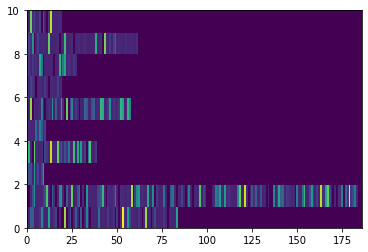

In [27]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*articles.shape[0]
input_word_ids = tf.concat([cls, articles], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

What you see above is a graphical representation of our tokenized tweets. First token is our classification token. Other colored blocks than background are other tokens. And background, well that's just padding.

## Mask and input type

The model expects two additional inputs:

* The input mask
* The input type

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the `input_word_ids`, and contains a `1` anywhere the `input_word_ids` is not padding.

In [ ]:
#input_word_ids

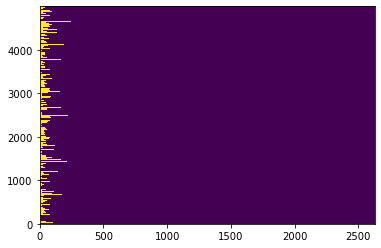

In [28]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

mightHere each yellow block has some input. We just make this for the model to differ between padding and input.

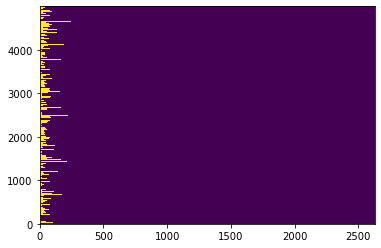

In [29]:
type_cls = tf.zeros_like(cls)
type_tweet = tf.ones_like(articles)
input_type_ids = tf.concat([type_cls, type_tweet], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

It's hard to see but we added an empty block in front of each tweet for the `[CLS]` token. Check tensor below

In [ ]:
input_type_ids

## Remake into a function for normal use

So at this point we have all of our three inputs:

1.   Tokens
2.   Input mask
3.   Input type

It will make our work easier both now and in the future if we remake everything into funcitons.



First let's set the max sequence lenght as we did in simple NN example.

In [30]:
lens = [len(i) for i in input_word_ids]

In [31]:
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

Max length is: 2626


In [32]:
#max_seq_length = int(1.5*max_seq_length)
max_seq_length = 192
print('Max length is:', max_seq_length)

Max length is: 192


Functions themselves.

In [33]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

And now we preprocess inputs.

In [34]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

## Initial training

We need to set up our model using the inputs we made, BERT model that we downloaded and an output layer based on num of classes we are using.

In [35]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

Set up the training parameters.

In [36]:
epochs = 5
batch_size = 6 # select based on your GPU resources
eval_batch_size = max_seq_length

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
#def recall_m(y_true, y_pred):
#    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#    recall = true_positives / (possible_positives + K.epsilon())
#    return recall

#def precision_m(y_true, y_pred):
#    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#    precision = true_positives / (predicted_positives + K.epsilon())
#    return precision

#def f1_m(y_true, y_pred):
#    precision = precision_m(y_true, y_pred)
#    recall = recall_m(y_true, y_pred)
#    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Compile the model.

In [37]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy']) # 'f1_m', 'precision_m', 'recall_m'

In [38]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 192)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 192)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 192)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [65]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/5
833/833 [==============================] - 129s 155ms/step - loss: 0.0352 - accuracy: 0.9872 - val_loss: 0.8975 - val_accuracy: 0.7926
Epoch 2/5
833/833 [==============================] - 130s 156ms/step - loss: 0.0354 - accuracy: 0.9876 - val_loss: 0.8975 - val_accuracy: 0.7926
Epoch 3/5
833/833 [==============================] - 130s 156ms/step - loss: 0.0379 - accuracy: 0.9856 - val_loss: 0.8975 - val_accuracy: 0.7926
Epoch 4/5
833/833 [==============================] - 130s 156ms/step - loss: 0.0391 - accuracy: 0.9854 - val_loss: 0.8975 - val_accuracy: 0.7926
Epoch 5/5
833/833 [==============================] - 130s 156ms/step - loss: 0.0403 - accuracy: 0.9866 - val_loss: 0.8975 - val_accuracy: 0.7926


In [ ]:
#df.iloc[18567].value_counts()

Evaluation

In [66]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9930
Testing Accuracy:  0.7926


In [67]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

y_pred1 = model.predict(X_test)
y_pred = np.argmax(y_pred1, axis=1)

print('Precsion: ', precision_score(y_test, y_pred , average="macro"))
print('Recall: ', recall_score(y_test, y_pred , average="macro"))
print('F1: ', f1_score(y_test, y_pred , average="macro"))

Precsion:  0.7717429275166672
Recall:  0.7609343908124395
F1:  0.7656244452897172


Evaluate test data

In [74]:
df_test

,comment_id,comment_text,Sub2_Engaging,Sub3_FactClaiming,Sub1_Toxic
0,3245,@USER Sie würden wahrscheinlich auch einen Kri...,0,0,0
1,3246,"@USER , ich glaube,Sie verkrnnen gründlich die...",0,0,0
2,3247,@USER: Man kann natürlich immerzu dieselbe Sau...,0,0,0
3,3248,"Als jemand, der im real existierenden Sozialis...",0,0,0
4,3249,Ihr größter Erfolg in ihrem Leben? KLASSENSPRE...,0,0,1
...,...,...,...,...,...
939,4184,@USER Da ist wie gegen Windmühlen kämpfen,0,0,0
940,4185,@USER Ihr Wort in Gottes Ohr.,0,0,1
941,4186,😂,0,0,0
942,4187,Mimimimi,0,0,1


//evaluate test data

In [73]:
comment =['@USER Sie würden wahrscheinlich auch einen Kriegstreiber/in wählen, wenn es gegen Trump ginge, warten sie es ab , vielleicht geht ihr Wunsch ja in Erfüllung...']
inputs = bert_encode(string_list=list(comment), 
                     tokenizer=tokenizer, 
                     max_seq_length=192)
prediction = model.predict(inputs)
print(prediction)

[[0.9172285  0.08277149]]


In [70]:
del df_test['Sub1_Toxic']

In [72]:
#some playing aaround
pred2=[]
comment = df_test['comment_text']
inputs = bert_encode(string_list=list(comment), 
                     tokenizer=tokenizer, 
                     max_seq_length=192)
prediction = model.predict(inputs)
print(prediction)
for x in prediction:
    pred2.append(0 if x[0] > x[1] else 1)

df_test['Sub1_Toxic'] = pred2
#print('Comment is', 'credible' if encoder.classes_[np.argmax(prediction)]>=0.7 else 'not credible or irrelevant')

[[9.1722810e-01 8.2771890e-02]
 [9.9968350e-01 3.1655849e-04]
 [7.9612845e-01 2.0387161e-01]
 ...
 [5.9935790e-01 4.0064210e-01]
 [4.6884695e-01 5.3115302e-01]
 [9.9891961e-01 1.0803882e-03]]


In [58]:
df_test

,comment_id,comment_text,Sub1_Toxic,Sub2_Engaging,Sub3_FactClaiming
0,3245,@USER Sie würden wahrscheinlich auch einen Kri...,0,0,0
1,3246,"@USER , ich glaube,Sie verkrnnen gründlich die...",0,0,0
2,3247,@USER: Man kann natürlich immerzu dieselbe Sau...,0,0,0
3,3248,"Als jemand, der im real existierenden Sozialis...",0,0,0
4,3249,Ihr größter Erfolg in ihrem Leben? KLASSENSPRE...,1,0,0
...,...,...,...,...,...
939,4184,@USER Da ist wie gegen Windmühlen kämpfen,0,0,0
940,4185,@USER Ihr Wort in Gottes Ohr.,1,0,0
941,4186,😂,0,0,0
942,4187,Mimimimi,1,0,0


In [52]:
df_test.comment_text.values[0]

'@USER Sie würden wahrscheinlich auch einen Kriegstreiber/in wählen, wenn es gegen Trump ginge, warten sie es ab , vielleicht geht ihr Wunsch ja in Erfüllung...'

In [57]:
df_test = df_test.assign(Sub3_FactClaiming=lambda x: 0)

In [59]:
df_testII = df_test.copy()

In [64]:
df_testII.to_csv(r'system_run_1.csv', index=False)

In [61]:
del df_testII['comment_text']

Noice plots are noice

In [336]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

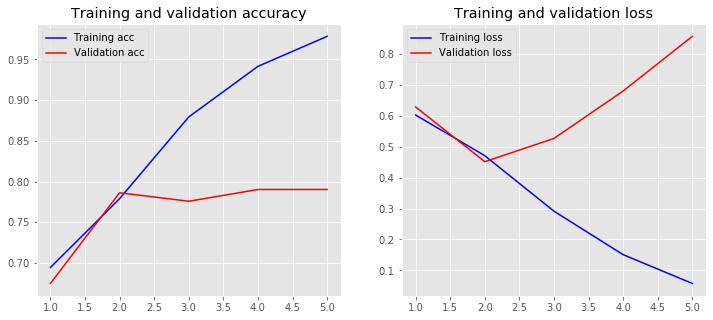

In [337]:
plot_history(history)

So, looking at the plot above we can see that at the 3rd epoch our `Validation Loss` jumped significantly even though `Validation Accuracy` stayed pretty much the same. If we would train it more on the same data it would significantly overtrain. \\
What we can do instead is make another training dataset, lower our learning rate commonly denoted as `lr`, recompile our model using new `lr` and then train it a bit more. \\
But before doing that we should save our model just in case if we would want to do the additional training in later sessions.

## Model saving for later use

Let's save our model for later use. Unfortunatelly we can't use the optimizer we used for model training to save. I get an error and I can't resolve it. So we will recompile our model before saving.

In [338]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [339]:
model_fname = 'Toxic_BERT_synthetic_data'
my_wd = ''

model.save(os.path.join(my_wd, model_fname))

INFO:tensorflow:Assets written to: Toxic_BERT_synthetic_data/assets


INFO:tensorflow:Assets written to: Toxic_BERT_synthetic_data/assets


### Validate saved model

Sometimes TF likes to corrupt your model when saving. It's always a good idea to check if everything loads correctly after save.

In [340]:
model_fname = 'Toxic_BERT_synthetic_data'
my_wd = ''

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [341]:
loss, accuracy, f1_score, precision, recall = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

ValueError: not enough values to unpack (expected 5, got 2)

In [ ]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

Now let's test

In [ ]:
encoder_fname = 'article_classes.npy'
my_wd = ''

encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

This is how our classes are encoded for the model.

In [ ]:
encoder.classes_

Input preprocessing.

In [ ]:
df = pd.read_csv('total_data.csv')
df.head()

In [ ]:
df.iloc[3]['content']

In [ ]:
article = df.iloc[3]['content']
inputs = bert_encode(string_list=list(article), 
                     tokenizer=tokenizerSaved, 
                     max_seq_length=512)

In [ ]:

prediction = model.predict(inputs)
print(prediction)
print('Article is', 'credible' if encoder.classes_[np.argmax(prediction)]<=0 else 'not credible or irrelevant')

Prediction.

In [ ]:
inputs